In [28]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV


# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import feature_functions as ff
# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)


In [41]:
ETF_NAME = './hist_data/stocks/TNA.txt'

df = pd.read_csv(ETF_NAME, sep=',')

df['Date'] = pd.to_datetime(df['Date'])
df.index = range(len(df))

df.head()

test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [42]:
def create_monthly_bars(df):
    """
    Create a new DataFrame with monthly bars from the given DataFrame.

    Args:
        df (pd.DataFrame): Original DataFrame with daily data. Must include a 'Date' column.

    Returns:
        pd.DataFrame: DataFrame with monthly bars (Open, High, Low, Close, Volume).
    """
    # Ensure 'Date' is the index for resampling
    if 'Date' not in df.columns:
        raise ValueError("The DataFrame must include a 'Date' column.")
    df = df.set_index('Date')

    # Resample to monthly frequency and aggregate
    monthly_bars = df.resample('M').agg({
        'Open': 'first',   # First value of the month
        'High': 'max',     # Maximum value of the month
        'Low': 'min',      # Minimum value of the month
        'Close': 'last',   # Last value of the month
        'Volume': 'sum'    # Total volume of the month
    }).dropna()  # Drop rows with NaN values (e.g., incomplete months)

    # Reset the index to make 'Date' a column again
    monthly_bars = monthly_bars.reset_index()

    return monthly_bars

        Date       Open       High        Low      Close       Volume
0 2015-08-31  40.040001  41.494999  29.605000  34.794998  226661200.0
1 2015-09-30  32.959999  37.919998  27.780001  29.500000  204778800.0
2 2015-10-31  29.639999  35.985001  27.850000  34.380001  217677600.0
3 2015-11-30  34.430000  38.439999  32.465000  37.529999  178456800.0
4 2015-12-31  38.009998  38.404999  29.645000  31.764999  231584600.0 117


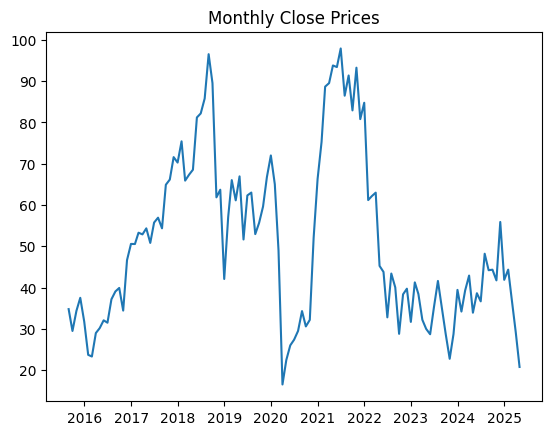

In [43]:
# Assuming df contains daily data with columns: Date, Open, High, Low, Close, Volume
monthly_bars = create_monthly_bars(df)

# Display the first few rows of the monthly bars
print(monthly_bars.head(), len(monthly_bars))

plt.plot(monthly_bars['Date'], monthly_bars['Close'])
plt.title('Monthly Close Prices')
plt.show()

#df = monthly_bars

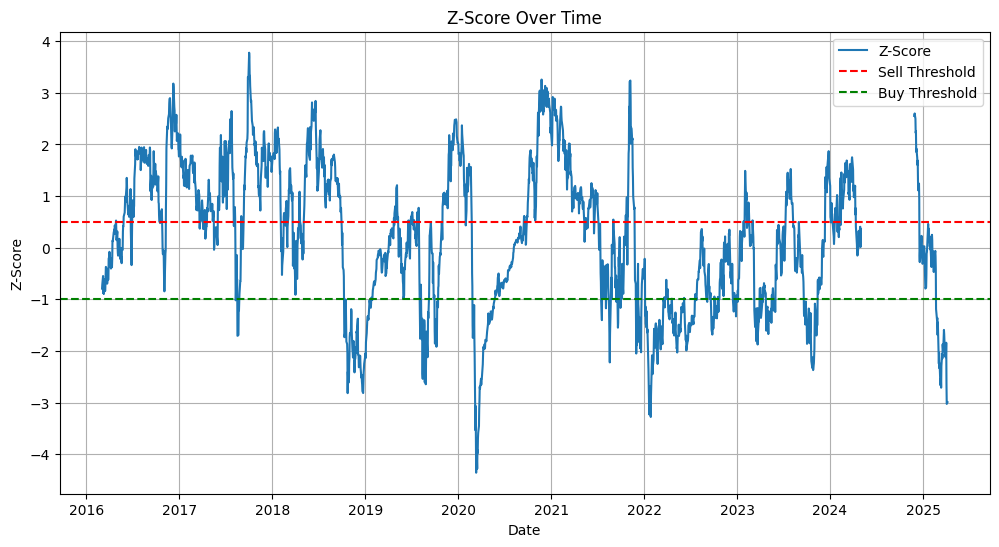

C:\Users\nick5\AppData\Local\Temp\ipykernel_20800\1903258427.py:76: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nick5\AppData\Local\Temp\ipykernel_20800\1903258427.py:76: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nick5\AppData\Local\Temp\ipykernel_20800\1903258427.py:76: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nick5\AppData\Local\Temp\ipykernel_20800\1903258427.py:76: SettingWithCopyWarning:


A v

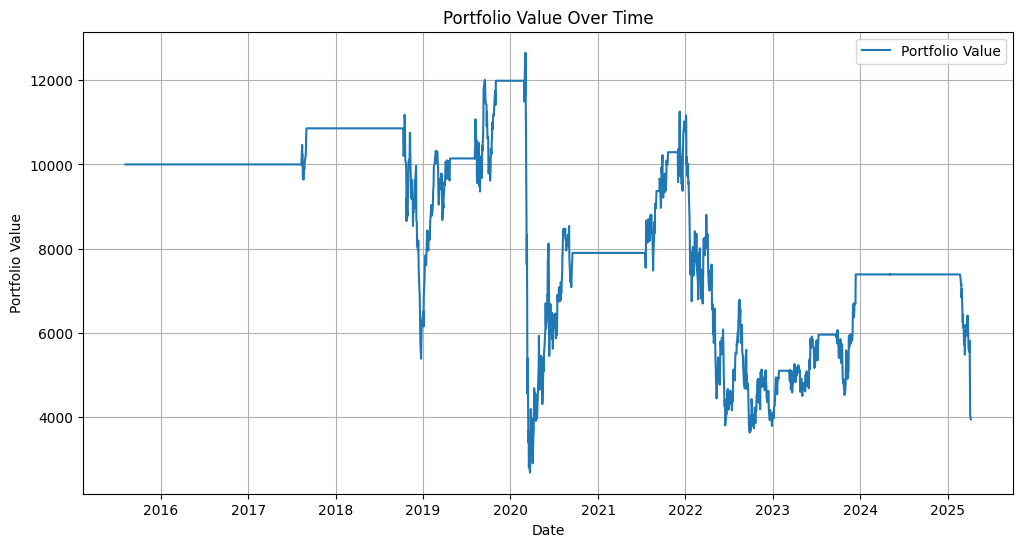

Initial Balance: $10000.00
Final Balance: $3941.66
Total Return: -60.58%


In [53]:
# Mean Reversion Strategy
window = 144  # Rolling window for mean
z_buy_threshold = 1 # Z-Score threshold for buy/sell signals
z_sell_threshold = .5 # Z-Score threshold for sell signals
# Calculate rolling mean and Z-Score
df['RollingMean'] = df['Close'].rolling(window=window).mean()
df['ZScore'] = (df['Close'] - df['RollingMean']) / df['Close'].rolling(window=window).std()

# Plot Z-Score
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['ZScore'], label='Z-Score')
plt.axhline(z_sell_threshold, color='red', linestyle='--', label='Sell Threshold')
plt.axhline(-z_buy_threshold, color='green', linestyle='--', label='Buy Threshold')
plt.title("Z-Score Over Time")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.legend()
plt.grid()
plt.show()

# Generate buy/sell signals
df['Signal'] = 0
df.loc[df['ZScore'] < -z_buy_threshold, 'Signal'] = 1  # Buy
df.loc[df['ZScore'] > z_sell_threshold, 'Signal'] = -1  # Sell

# Plot signals on the price chart
fig = make_subplots(rows=2, cols=1)

# Add OHLC chart
fig.add_trace(go.Ohlc(x=df['Date'],
                      open=df['Open'],
                      high=df['High'],
                      low=df['Low'],
                      close=df['Close'],
                      name='Price'), row=1, col=1)

# Add buy signals
fig.add_trace(go.Scatter(x=df.loc[df['Signal'] == 1, 'Date'],
                         y=df.loc[df['Signal'] == 1, 'Close'],
                         mode='markers',
                         marker=dict(color='green', size=10),
                         name='Buy Signal'), row=1, col=1)

# Add sell signals
fig.add_trace(go.Scatter(x=df.loc[df['Signal'] == -1, 'Date'],
                         y=df.loc[df['Signal'] == -1, 'Close'],
                         mode='markers',
                         marker=dict(color='red', size=10),
                         name='Sell Signal'), row=1, col=1)

# Add volume chart
fig.add_trace(go.Scatter(x=df['Date'], y=df['Volume'], name='Volume'), row=2, col=1)

# Update layout
fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(title="Mean Reversion Strategy Signals", height=800)
fig.show()

# Backtesting the strategy
initial_balance = 10000  # Starting capital
balance = initial_balance
position = 0  # Current position (number of shares)
transaction_cost = 0.001  # 0.1% per trade
df['Portfolio'] = 0  # Track portfolio value

for i in range(len(df)):
    # Buy signal
    if df['Signal'].iloc[i] == 1 and balance > 0:  # Ensure we have balance to buy
        position = (balance * (1 - transaction_cost)) / df['Close'].iloc[i]  # Buy as many shares as possible
        balance = 0  # Use all balance
    # Sell signal
    elif df['Signal'].iloc[i] == -1 and position > 0:  # Ensure we have shares to sell
        balance = position * df['Close'].iloc[i] * (1 - transaction_cost)  # Sell all shares
        position = 0  # Clear position
    # Update portfolio value
    df['Portfolio'].iloc[i] = balance + (position * df['Close'].iloc[i])

# Handle the case where no trades occur
if df['Portfolio'].iloc[-1] == 0:
    df['Portfolio'].iloc[-1] = initial_balance

# Plot portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Portfolio'], label='Portfolio Value')
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()
plt.show()

# Print final portfolio value
final_balance = balance + (position * df['Close'].iloc[-1])
print(f"Initial Balance: ${initial_balance:.2f}")
print(f"Final Balance: ${final_balance:.2f}")
print(f"Total Return: {((final_balance - initial_balance) / initial_balance) * 100:.2f}%")

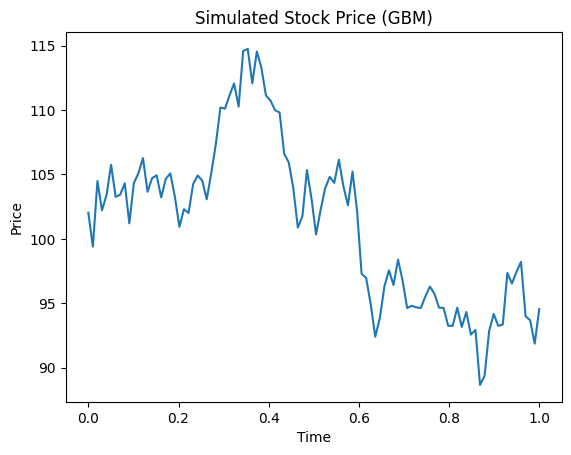

In [10]:

# Parameters
S0 = 100  # Initial stock price
mu = 0.05  # Drift
sigma = 0.2  # Volatility
T = 1  # Time horizon (1 year)
dt = 0.01  # Time step
n = int(T / dt)  # Number of steps

# Simulate Wiener process
np.random.seed()
W = np.random.normal(0, np.sqrt(dt), n).cumsum()

# Simulate GBM
t = np.linspace(0, T, n)
S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

# Plot
import matplotlib.pyplot as plt
plt.plot(t, S)
plt.title("Simulated Stock Price (GBM)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()